In [281]:
import tensorflow as tf
import torch
# inspired from https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX

GPU Available, using GPU 




Epoch number1


/opt/conda/conda-bld/pytorch_1587428398394/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


Average training loss:  1.7555867419748146
Validation Accuracy:  0.6122045454545455
Epoch number2
Average training loss:  1.0737100286825576
Validation Accuracy:  0.6388409090909091


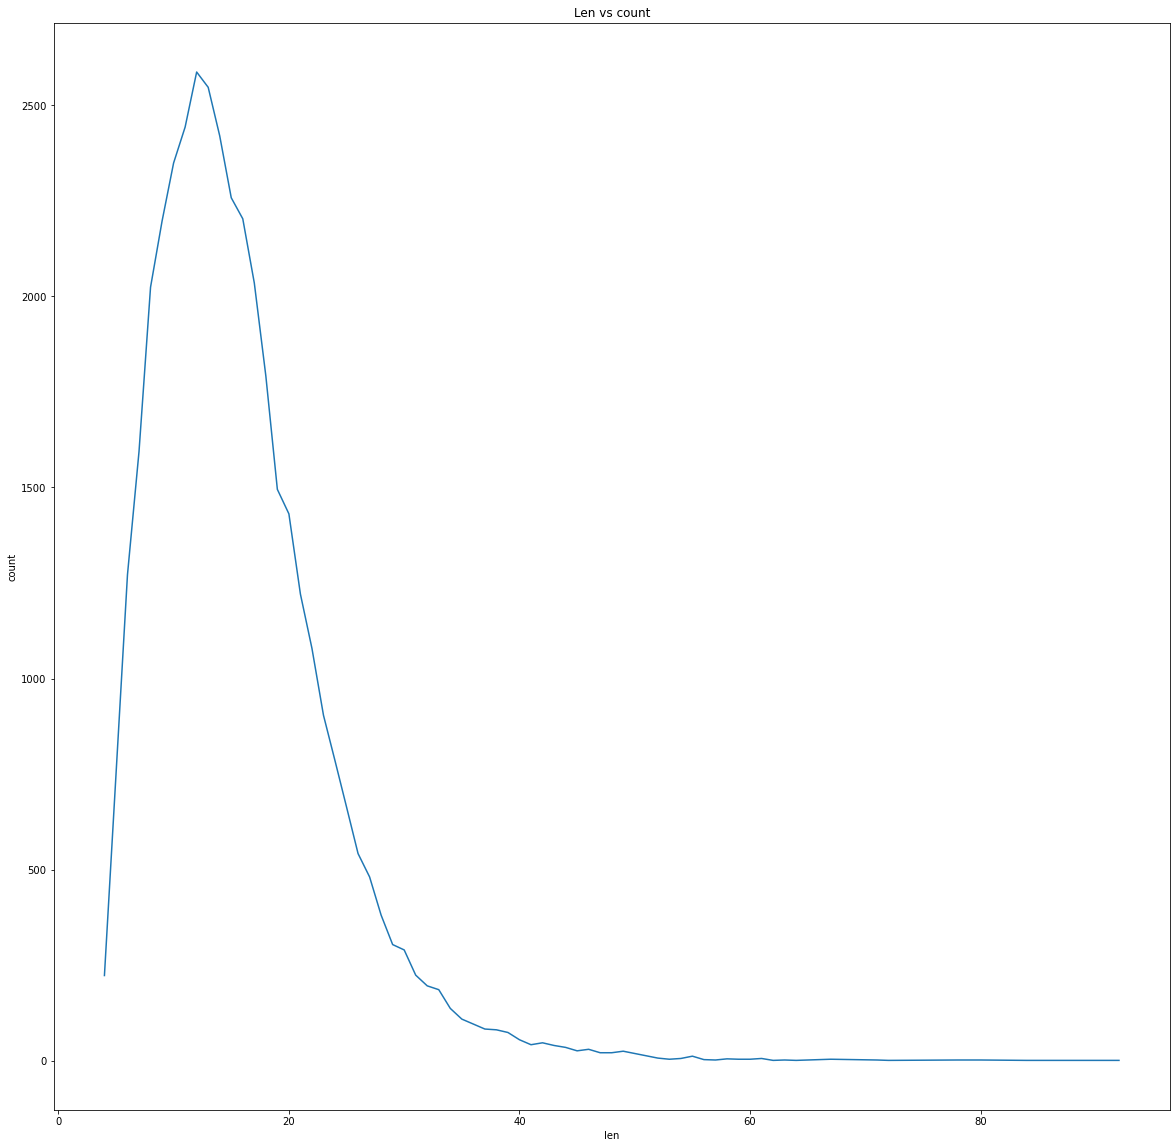

In [1]:
import torch
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, random_split
# inspired from https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
import pandas as pd
import random
import numpy as np
import sys
from collections import defaultdict
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# Function to calculate the accuracy of our predictions vs labels
def get_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

n = len(sys.argv)

dataset_dir_path = '/kaggle/input/col774-2022'
train_x = '/train_x.csv'
train_y = '/train_y.csv'
images_folder = '/images/images'

# if(n != 2):
#     print("Insufficient number of arguments passed, exiting...")
#     exit(1)
# else:
#     dataset_dir_path = sys.argv[1]

if torch.cuda.is_available():    
    print("GPU Available, using GPU \n")
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

train_df_x = pd.read_csv(dataset_dir_path+'/train_x.csv')
train_df_y = pd.read_csv(dataset_dir_path+'/train_y.csv')
train_df_x2 = pd.read_csv(dataset_dir_path+'/non_comp_test_x.csv')
train_df_y2 = pd.read_csv(dataset_dir_path+'/non_comp_test_y.csv')
train_df2 = train_df_x2.merge(train_df_y2)
train_df = train_df_x.merge(train_df_y)
train_df = train_df[['Title', 'Genre']]
train_df2 = train_df2[['Title', 'Genre']]
# if using non-cop test data for training aswell, concat the two dataframes
train_df = pd.concat([train_df, train_df2], axis=0)
# train_df.head(10)

titles = train_df['Title'].values
labels = train_df['Genre'].values

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def return_zero():
    return 0
lengths = defaultdict(return_zero)
for title in titles:
    input_ids = tokenizer.encode(title, add_special_tokens=True)
    lengths[len(input_ids)]+=1

keys = sorted(list(lengths.keys()))
vals = [lengths[key] for key in keys]
plt.figure(figsize=(20, 20))
plt.plot(keys, vals)
plt.title('Len vs count')
plt.ylabel('count')
plt.xlabel('len')
plt.savefig('vis.jpg')
max_pad_length = 30
to_pad = True
# post 40-42 the count of title lengths is negligible, to avoid trailing zeroes, setting pad length to 30

input_ids = []
attention_masks = []
for title in titles:
    encoded_dict = tokenizer.encode_plus(
                        title,                      
                        add_special_tokens = True, 
                        max_length = max_pad_length,           
                        pad_to_max_length = to_pad,
                        return_attention_mask = True,   
                        return_tensors = 'pt',    
                   )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

dataset = TensorDataset(input_ids, attention_masks, labels)
train_dataset, val_dataset = random_split(dataset, [int(0.9 * len(dataset)), len(dataset) - int(0.9 * len(dataset))])

batch_size = 32

train_dataloader = DataLoader(train_dataset,sampler = RandomSampler(train_dataset),batch_size = 32 )
validation_dataloader = DataLoader(val_dataset, sampler = SequentialSampler(val_dataset), batch_size = 32 )

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 30, output_attentions = False,output_hidden_states = False)
model.cuda()

# experimented with lrs fro 2e-5 to 5e-5
optimizer = AdamW(model.parameters(), lr = 5e-5, eps = 1e-8)
# epochs experimented between 2, 3 and 4 
epochs = 2
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)
random.seed(42)

for i in range(0, epochs):
    print('Epoch number' + str(i+1))
    total_loss = 0
    model.train()
    len_train = len(train_dataloader)
    for step, batch in enumerate(train_dataloader):
        model.zero_grad()        
        loss, logits = model(batch[0].to(device), token_type_ids=None, attention_mask=batch[1].to(device), labels=batch[2].to(device))
        total_loss += loss.item()
        loss.backward()
        # prevent exploding gradients issue
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        # baseline is average loss
    baseline = total_loss / len_train     
    print("Average training loss: ", baseline)
    # validation part
    len_val = len(validation_dataloader)
    model.eval()
    val_acc = 0
    val_loss = 0
    nb_eval_steps = 0
    for batch in validation_dataloader:
        with torch.no_grad():        
            (loss, logits) = model(batch[0].to(device), token_type_ids=None, attention_mask=batch[1].to(device),labels=batch[2].to(device))
        val_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = batch[2].to('cpu').numpy()
        val_acc += get_accuracy(logits, label_ids)
    avg_acc = val_acc / len_val
    print("Validation Accuracy: ", avg_acc)
    # avg_val_loss = val_loss / len_val

# Test time
df = pd.read_csv(dataset_dir_path+'/comp_test_x.csv')
titles = df['Title'].values

input_ids = []
attention_masks = []
for title in titles:
    encoded_dict = tokenizer.encode_plus(title,add_special_tokens = True, max_length = max_pad_length,pad_to_max_length = to_pad,return_attention_mask = True,return_tensors = 'pt')   
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

test_data = TensorDataset(input_ids, attention_masks)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=32)

model.eval()
predictions = []
for batch in test_dataloader:
  batch = tuple(t.to(device) for t in batch)
  batch_input_ids, batch_input_mask = batch
  with torch.no_grad():
      # get logit predictions
      outputs = model(batch_input_ids, token_type_ids=None, attention_mask=batch_input_mask)
  logits = outputs[0].detach().cpu().numpy()
  predictions.append(logits)


final = []
for i in range(len(predictions)):
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()             
  final.append(pred_labels_i) 
final2 = []
for x in final:
    final2.extend(x)
submit = pd.DataFrame(final2,columns=['Genre'])
submit.to_csv('comp_test_y.csv',index=True,index_label='Id')


In [282]:
if torch.cuda.is_available():    
    print("GPU Available, using GPU \n")
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

GPU Available, using GPU 



In [283]:
# !pip install transformers=='2.8.0'

In [284]:
import pandas as pd

train_df_x = pd.read_csv('/kaggle/input/col774-2022/train_x.csv')
train_df_y = pd.read_csv('/kaggle/input/col774-2022/train_y.csv')
train_df_x2 = pd.read_csv('/kaggle/input/col774-2022/non_comp_test_x.csv')
train_df_y2 = pd.read_csv('/kaggle/input/col774-2022/non_comp_test_y.csv')
train_df2 = train_df_x2.merge(train_df_y2)
train_df = train_df_x.merge(train_df_y)
train_df = train_df[['Title', 'Genre']]
train_df2 = train_df2[['Title', 'Genre']]

# if using non-cop test data for training aswell, concat the two dataframes
train_df = pd.concat([train_df, train_df2], axis=0)

# train_df.head(10)

len(train_df)

39900

In [285]:
sentences = train_df['Title'].values
labels = train_df['Genre'].values

In [286]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt

def returnZero():
    return 0
max_len = 0
lengths = defaultdict(returnZero)
for sent in sentences:
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    lengths[len(input_ids)]+=1
    max_len = max(max_len, len(input_ids))
lengths

keys=sorted(list(lengths.keys()))
vals = [lengths[key] for key in keys]
plt.figure(figsize=(20, 20))
plt.plot(keys, vals)
plt.title('Len vs count')
plt.ylabel('count')
plt.xlabel('len')
plt.savefig('vis.jpg')

# post 40-42 the count of title lengths is negligible, to avoid trailing zeroes, setting pad length to 42

NameError: name 'sentences' is not defined

In [289]:
max_pad_length = 35
to_pad = True

In [290]:
input_ids = []
attention_masks = []

for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_pad_length,           # Pad & truncate all sentences.
                        pad_to_max_length = to_pad,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

Original:  Uncertain Justice: The Roberts Court : and the Constitution
Token IDs: tensor([ 101, 9662, 3425, 1024, 1996, 7031, 2457, 1024, 1998, 1996, 4552,  102,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0])


Divide up our training set to use 90% for training and 10% for validation.

In [291]:
from torch.utils.data import TensorDataset, random_split

dataset = TensorDataset(input_ids, attention_masks, labels)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [292]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 30, # The number of output labels is 30
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

model.cuda()

In [295]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [296]:
from transformers import get_linear_schedule_with_warmup
# epochs experimented between 2, 3 and 4 
epochs = 2
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

In [297]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [299]:
import random
import numpy as np

seed_val = 66

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

for epoch_i in range(0, epochs):

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()        
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    avg_train_loss = total_train_loss / len(train_dataloader)            

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))


    print("")
    print("Running Validation...")
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        with torch.no_grad():        
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))


======== Epoch 1 / 2 ========
Training...
  Batch    40  of  1,123.    Elapsed: 0:00:05.
  Batch    80  of  1,123.    Elapsed: 0:00:10.
  Batch   120  of  1,123.    Elapsed: 0:00:15.
  Batch   160  of  1,123.    Elapsed: 0:00:20.
  Batch   200  of  1,123.    Elapsed: 0:00:26.
  Batch   240  of  1,123.    Elapsed: 0:00:31.
  Batch   280  of  1,123.    Elapsed: 0:00:36.
  Batch   320  of  1,123.    Elapsed: 0:00:41.
  Batch   360  of  1,123.    Elapsed: 0:00:46.
  Batch   400  of  1,123.    Elapsed: 0:00:51.
  Batch   440  of  1,123.    Elapsed: 0:00:56.
  Batch   480  of  1,123.    Elapsed: 0:01:02.
  Batch   520  of  1,123.    Elapsed: 0:01:07.
  Batch   560  of  1,123.    Elapsed: 0:01:12.
  Batch   600  of  1,123.    Elapsed: 0:01:17.
  Batch   640  of  1,123.    Elapsed: 0:01:22.
  Batch   680  of  1,123.    Elapsed: 0:01:27.
  Batch   720  of  1,123.    Elapsed: 0:01:32.
  Batch   760  of  1,123.    Elapsed: 0:01:38.
  Batch   800  of  1,123.    Elapsed: 0:01:43.
  Batch   840  of

In [300]:
import pandas as pd

df = pd.read_csv('/kaggle/input/col774-2022/comp_test_x.csv')

sentences = df['Title'].values

input_ids = []
attention_masks = []

for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_pad_length,           # Pad & truncate all sentences.
                        pad_to_max_length = to_pad,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )   
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
 
batch_size = 32  

prediction_data = TensorDataset(input_ids, attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [301]:

model.eval()

predictions = []

for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  b_input_ids, b_input_mask = batch

  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)
  logits = outputs[0]
  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  predictions.append(logits)

Predicting labels for 11,514 test sentences...
    DONE.


In [302]:
final = []
for i in range(len(predictions)):
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()             
  final.append(pred_labels_i) 

In [303]:
final2 = []
for x in final:
    final2.extend(x)


In [304]:
submit = pd.DataFrame(final2,columns=['Genre'])
submit.to_csv('bert_epoch_2_full_train_35maxlen_5e5.csv',index=True,index_label='Id')